In [1]:
# import torch
import numpy as np
import data_pipes

df_path = "processed_aapl_data.csv"
data = data_pipes.process_df(df_path)

In [2]:
from torch import nn

class georgia_1(nn.Module):
    def __init__(self, config, win_past=20, features=19):
        super().__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Flatten())

        for idx in range(len(config['neurons'])):
            if config['activations'][idx] == 'relu':
                activation = nn.ReLU()
            elif config['activations'][idx] == 'selu':
                activation = nn.SELU()
            elif config['activations'][idx] == 'sigmoid':
                activation = nn.Sigmoid()
            elif config['activations'][idx] == 'tanh':
                activation = nn.Tanh()
            elif config['activations'][idx] == 'none':
                activation = "none"
            else:
                raise ValueError(f"Unrecognized activation function at index {idx}: {activations[idx]}")

            if idx == 0:
                self.layers.append(nn.Linear(features*win_past, config['neurons'][idx]))
            else:
                self.layers.append(nn.Linear(config['neurons'][idx - 1], config['neurons'][idx]))

            if activation != 'none':
                self.layers.append(activation)

            self.layers.append(nn.Dropout(config['dropouts'][idx]))
        
        self.init_weights()
        
    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.trunc_normal_(m.weight, mean=0, std=1)  # Set mean=0, std=1
                if m.bias is not None:
                    nn.init.zeros_(m.bias)  # Optional: Initialize biases to 0

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)

        return x

In [ ]:
import time
import torch
from torch import optim
import torch_ops as ops
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

x, y = data["x"], data["y"]
v_split = 0.1
v_cutoff = int(len(x)*v_split)
x_t = torch.tensor(x[:v_cutoff], dtype=torch.float32).to(device)
x_v = torch.tensor(x[v_cutoff:], dtype=torch.float32).to(device)
y_t = torch.tensor(y[:v_cutoff], dtype=torch.float32).to(device)
y_v = torch.tensor(y[v_cutoff:], dtype=torch.float32).to(device)

win_past, features = x.shape[1], x.shape[2]
epochs, batch_size, lr, l2_decay = 1000, 64, 5e-4, 0
rate_schedule = ops.rate_schedule_cosine(
    rate_max=5e-3,
    rate_min=5e-5,
    epochs=epochs,
    decay_param=1e-2)

best_score = 1
scores = []
verbose = True
for iteration in range(1):
    # model_config = random_model_config()
    model_config = {
        'neurons': [64, 1],
        'activations': ['selu','tanh'],
        'dropouts': [0.0, 0.0]
    }

    model = georgia_1(model_config, win_past=win_past, features=features).to(device)
    loss_fn = nn.SmoothL1Loss()
    optimizer = optim.NAdam(params=model.parameters(), lr=lr, weight_decay=l2_decay)

    if verbose:
        loss = ops.test_loop(x_t, y_t, model, loss_fn, batch_size)
        test_loss = ops.test_loop(x_v, y_v, model, loss_fn, batch_size)
        print("---------- Epoch 0 ----------")
        print(f"loss: {loss:1.4f}, test loss: {test_loss:1.4f}")

    best_test_loss = 999
    t0 = time.perf_counter()
    for epoch in range(epochs):
        for param_group in optimizer.param_groups:
            param_group['lr'] = rate_schedule[epoch]
        loss = ops.train_loop(x_t, y_t, model, loss_fn, optimizer, batch_size)
        test_loss_new = ops.test_loop(x_v, y_v, model, loss_fn, batch_size)
        best_test_loss = min(best_test_loss, test_loss_new)

        if verbose:
            if test_loss_new < test_loss or epoch == epochs - 1:
                print(f"---------- Epoch {epoch + 1} ----------")
                print(f"loss: {loss:1.4f}, test loss: {test_loss_new:1.4f}")
            
            improvement = test_loss_new < test_loss
            if improvement:
                test_loss = test_loss_new
                print(f"Checkpoint: test loss = {test_loss:1.4f} <---------------")
                torch.save(model.state_dict(), r"models/hanzo_0")

    t1 = time.perf_counter()
    model_config['score'] = best_test_loss
    scores.append(model_config)
    best_score = min(best_score, best_test_loss)

    print(f"Iteration {iteration}, t = {t1 - t0:1.2f}, score = {best_test_loss:1.4f}, best score = {best_score:1.4f}")

---------- Epoch 0 ----------
loss: 0.5548, test loss: 0.4735
---------- Epoch 1000 ----------
loss: 0.4166, test loss: 0.5688
Iteration 0, t = 16.33, score = 0.4755, best score = 0.4755


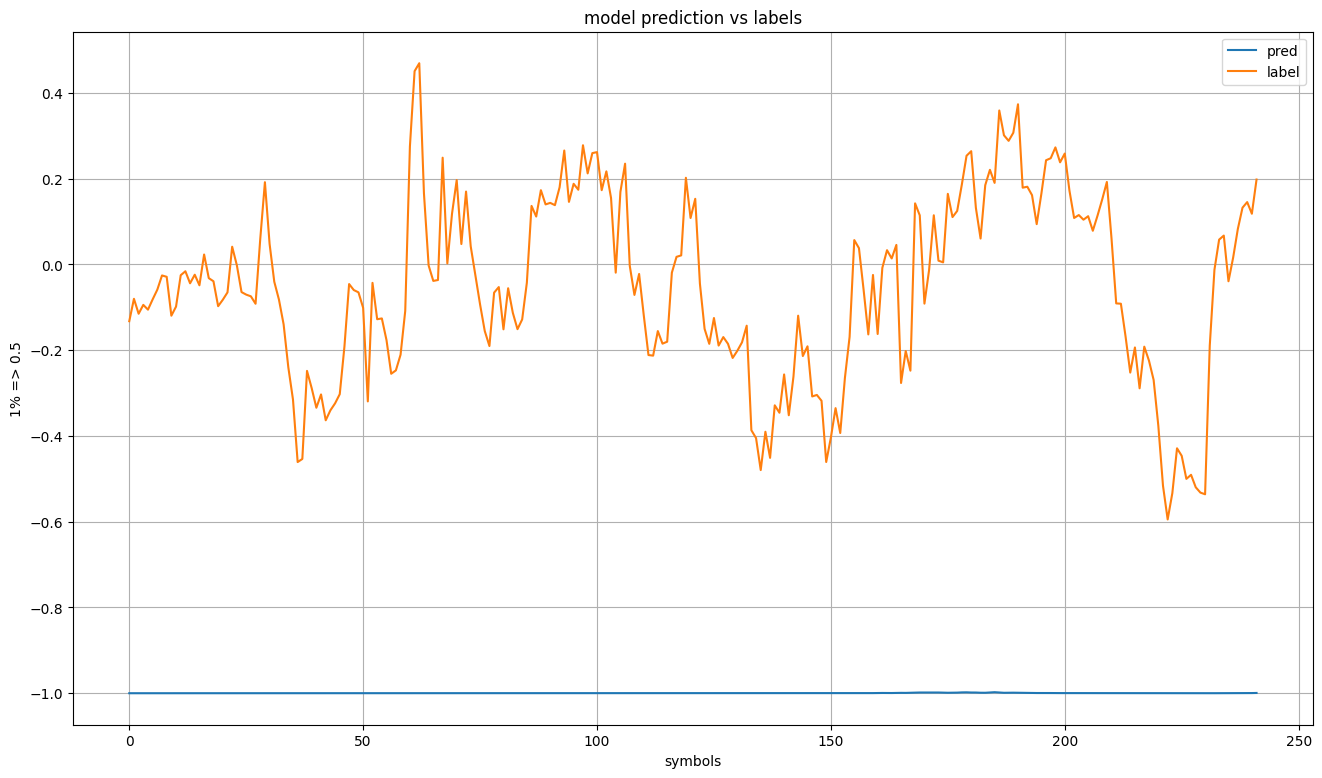

In [34]:
from matplotlib import pyplot as plt

# pred = model(x_v).to('cpu').detach().numpy()
# label = y_v.to('cpu').detach().numpy()

pred = model(x_t).to('cpu').detach().numpy()
label = y_t.to('cpu').detach().numpy()

sym_index = np.arange(pred.shape[1])
plt.figure(figsize=(16, 9))
plt.title("model prediction vs labels")
plt.xlabel("symbols")
plt.ylabel("1% => 0.5")

plt.plot(pred, label="pred")
plt.plot(label, label="label")

plt.grid()
plt.legend()
plt.show()